# Multi task learning - baseline models
This post will explore building elastic net models using the PyTorch library.
I will compare various scenarios with the implementations in scikit-learn to validate them.

Start by importing stuff:

In [1]:
import pandas as pd

import torch
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_64231/3790832345.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Let's generate some data.
We will build a common latent space and multiple outputs that build from that.
We need some non-linearity otherwise we will just end up with each output being a linear combination of features.


Data is generated as follows:

x -> x_l
x_l -> y_0
x_l -> y_1


In [2]:
import numpy as np

n = 10_000
x_dim = 20
l_dim = 10
np.random.seed(10)

x = np.random.uniform(-1, 1, size=(n,x_dim))
w_l = np.random.uniform(-1, 1, size=(x_dim, l_dim))
x_l = np.dot(x, w_l)

w_0 = np.random.uniform(-1, 1, size=(l_dim, 1))
y_0 = np.dot(x_l, w_0) + np.random.normal(size=(n,1))
y_1 = ((y_0 + np.random.normal(size=(n,1)))>0.5)*1.0

y = np.hstack([y_0, y_1])

# specify outcome types
col_reg = [0]
col_class = [1]

# TODO:
# Add more non-linearities (with splines?)

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_64231/3748256204.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


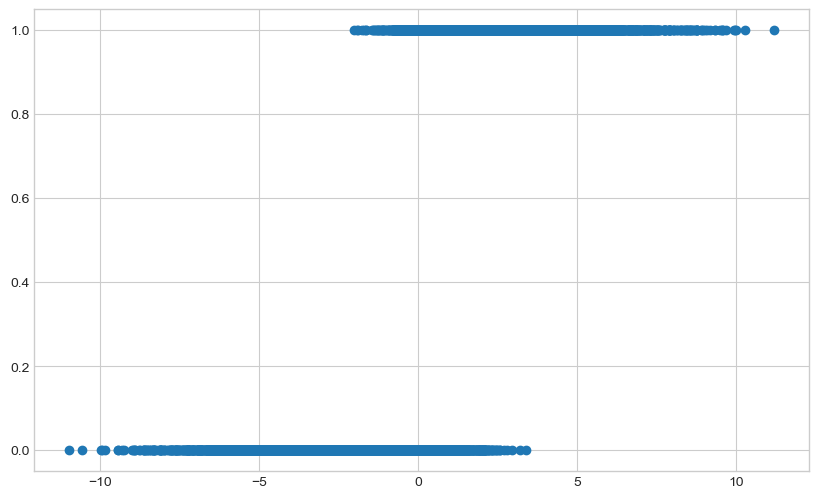

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y[:,0],y[:,1])
fig.show()

## Train models

In [4]:
models = {}
y_train_est = {}
y_test_est = {}

Split train/test

In [5]:
x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]

### Linear models

In [6]:
import sklearn.linear_model

models["linear"] = []
y_train_est["linear"] = []
y_test_est["linear"] = []
for _col in range(y.shape[1]):
    print(y_train[:, _col].shape)
    if _col in col_reg:
        _model = sklearn.linear_model.LinearRegression()
        _model.fit(x_train, y_train[:, _col])
        _y_train_est = _model.predict(x_train)
        _y_test_est = _model.predict(x_test)
    elif _col in col_class:
        _model = sklearn.linear_model.LogisticRegression()
        _model.fit(x_train, y_train[:, _col])
        _y_train_est = _model.predict_proba(x_train)[:, 1]
        _y_test_est = _model.predict_proba(x_test)[:, 1]
    y_train_est["linear"].append(_y_train_est)
    y_test_est["linear"].append(_y_test_est)
    models["linear"].append(_model)

y_train_est["linear"] = np.stack(y_train_est["linear"]).transpose()
y_test_est["linear"] = np.stack(y_test_est["linear"]).transpose()


(5000,)
(5000,)


### GBMs

Fit GBMs to each output

In [7]:
import sklearn.ensemble

models["gbm"] = []
y_train_est["gbm"] = []
y_test_est["gbm"] = []
for _col in range(y.shape[1]):
    print(y_train[:, _col].shape)
    if _col in col_reg:
        _model = sklearn.ensemble.GradientBoostingRegressor()
        _model.fit(x_train, y_train[:,_col])
        _y_train_est = _model.predict(x_train)
        _y_test_est = _model.predict(x_test)
    elif _col in col_class:
        _model = sklearn.ensemble.GradientBoostingClassifier()
        _model.fit(x_train, y_train[:,_col])
        _y_train_est = _model.predict_proba(x_train)[:,1]
        _y_test_est = _model.predict_proba(x_test)[:,1]
    y_train_est["gbm"].append(_y_train_est)
    y_test_est["gbm"].append(_y_test_est)
    models["gbm"].append(_model)

y_train_est["gbm"] = np.stack(y_train_est["gbm"]).transpose()
y_test_est["gbm"] = np.stack(y_test_est["gbm"]).transpose()


(5000,)
(5000,)


## Train multi-task neural net

Next we prep data for PyTorch by converting to Tensors and
creating dataloaders.

We need to use the whole dataset in each step rather than smaller batches to match the way
sklearn has it's cost function setup.

In [8]:
import torch.utils.data

x_train_t = torch.Tensor(x_train)
y_train_t = torch.Tensor(y_train)
x_test_t = torch.Tensor(x_test)
y_test_t = torch.Tensor(y_test)

dataset_train = torch.utils.data.TensorDataset(x_train_t, y_train_t)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=x_train_t.shape[0], shuffle=True)
dataset_test = torch.utils.data.TensorDataset(x_test_t, y_test_t)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=x_test_t.shape[0], shuffle=True)

### Model definition
Now let's create a PyTorch elastic net model with `pytorch-lightning`.

We create a single linear layer network which represents a linear model.
We need to support both L1 and L2 losses in order to create the elastic regularisation.
Note - both of those `l1_reg` and `l2_reg` methods do not include the intercept. [Why? - more details](https://stats.stackexchange.com/questions/86991/reason-for-not-shrinking-the-bias-intercept-term-in-regression?rq=1).

This loss comes together in the `training_step` where we simply add the loss function outputs.

In [94]:
import pytorch_lightning as pl
import copy
import torch


class MLTNN(pl.LightningModule):
    def __init__(
        self,
        col_reg: list[int],
        col_class: list[int],
        n_inputs: int = 1,
        learning_rate=0.05,
    ):
        super().__init__()

        self.learning_rate = learning_rate
        self.train_log = []
        self.val_log = []

        n_outputs = max(col_reg + col_class) + 1
        self.loss_fcns = []
        for _idx in range(n_outputs):
            if _idx in col_reg:
                self.loss_fcns.append(torch.nn.MSELoss())
            if _idx in col_class:
                self.loss_fcns.append(torch.nn.BCEWithLogitsLoss())

        # embedding
        emb_size = [n_inputs, 64, 32, 16, 8]
        emb_layers = []
        for _idx in range(len(emb_size) - 2):
            emb_layers.append(torch.nn.Linear(emb_size[_idx], emb_size[_idx + 1]))
            emb_layers.append(torch.nn.ReLU())
        self.embedding = torch.nn.Sequential(
            *emb_layers, torch.nn.Linear(emb_size[-2], emb_size[-1])
        )

        def _get_output_head_layers(col_type: str):
            # general output head layers
            output_size = [emb_size[-1], 4]
            output_layers = []
            for _idx in range(len(output_size) - 1):
                output_layers.append(
                    torch.nn.Linear(output_size[_idx], output_size[_idx + 1])
                )
                output_layers.append(torch.nn.ReLU())

            # outcome specific layer
            if col_type == "reg":
                return torch.nn.Sequential(
                    *output_layers, torch.nn.Linear(output_size[-1], 1)
                )
            
                # mean = self.mean_linear(outputs)
                # scale = torch.nn.functional.softplus(self.scale_linear(outputs))
            if col_type == "class":
                return torch.nn.Sequential(
                    *output_layers, torch.nn.Linear(output_size[-1], 1)
                )

        # output head for each output
        self.output_heads = []
        n_outputs = max(col_reg + col_class) + 1
        for _idx in range(n_outputs):
            _output_layers = _get_output_head_layers(col_type="reg" if _idx in col_reg else "class")
            self.output_heads.append(_output_layers)


    def forward(self, x):
        emb = self.embedding(x)
        return torch.concat(
            [_output_head(emb) for _output_head in self.output_heads], dim=1
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)

        loss = torch.tensor(0.0)
        losses = []
        for _idx, _loss in enumerate(self.loss_fcns):
            losses.append(_loss(y_hat[:,_idx], y[:,_idx]))
            loss += losses[-1]
            
        self.log("loss", loss)
        self.train_log.append([_loss.detach().numpy() for _loss in losses])
        return loss
    
    def validation_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)

        loss = torch.tensor(0.0)
        losses = []
        for _idx, _loss in enumerate(self.loss_fcns):
            losses.append(_loss(y_hat[:,_idx], y[:,_idx]))
            loss += losses[-1]
            
        self.log("val_loss", loss)
        self.val_log.append([_loss.detach().numpy() for _loss in losses])
        
        return loss


def plot_convergence(train_loss):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_loss)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Train loss")
    fig.show()

def loss_fn_loglike(y_hat, y):
    negloglik = -y_hat.log_prob(y)
    return torch.mean(negloglik)


model = MLTNN(n_inputs=x_dim, col_reg=col_reg, col_class=col_class)
model.output_heads
model


MLTNN(
  (embedding): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [95]:
model(x_train_t)
x_batch, y_batch = next(iter(dataloader_train))
model.training_step((x_batch, y_batch))


/Users/stantoon/miniconda3/envs/huggingface_env/lib/python3.11/site-packages/pytorch_lightning/core/module.py:410: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(10.8492, grad_fn=<AddBackward0>)

In [96]:
# fit model
trainer = pl.Trainer(max_epochs=100, accelerator='cpu')
trainer.fit(model, dataloader_train, dataloader_test)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/huggingface_env/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Sequential | 4.1 K 
-----------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/stantoon/miniconda3/envs/huggingface_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/huggingface_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/stantoon/miniconda3/envs/huggingface_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/huggingface_env/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s, v_num=16]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_64231/2883834528.py:114: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


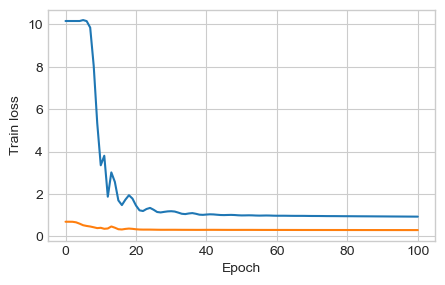

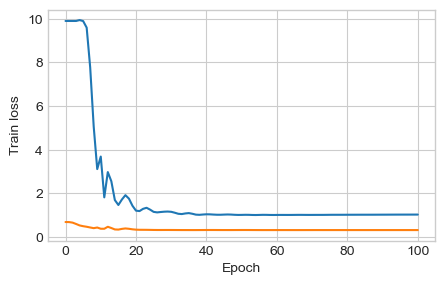

In [97]:
plot_convergence(model.train_log)
plot_convergence(model.val_log)

Get outputs for comparison

Take `expit` of the model outputs for classifiers.

In [98]:
_y_est = model(x_train_t)
_y_est[:,col_class] = torch.sigmoid(_y_est[:,col_class])
y_train_est["mltnn"] = _y_est.detach().numpy()

_y_est = model(x_test_t)
_y_est[:,col_class] = torch.sigmoid(_y_est[:,col_class])
y_test_est["mltnn"] = _y_est.detach().numpy()


Check:
* model weights vary between the output heads
* embedding is training

## Evaluation

In [99]:
import sklearn.metrics

train_loss = {}
test_loss = {}
for _name, val in y_train_est.items():
    train_loss[_name] = [
        sklearn.metrics.mean_squared_error(y_train[:, col_reg], y_pred=val[:, col_reg]),
        sklearn.metrics.log_loss(y_train[:, col_class], y_pred=val[:, col_class]),
    ]
for _name, val in y_test_est.items():
    test_loss[_name] = [
        sklearn.metrics.mean_squared_error(y_test[:, col_reg], y_pred=val[:, col_reg]),
        sklearn.metrics.log_loss(y_test[:, col_class], y_pred=val[:, col_class]),
    ]


print("train loss")
display(train_loss)
print("test loss")
display(test_loss)


train loss


{'linear': [1.0105022635689926, 0.3035839940101893],
 'gbm': [1.1233133678413287, 0.2952174462338842],
 'mltnn': [0.9266540144713317, 0.2930765276634722]}

test loss


{'linear': [0.985585055939, 0.31785885743381975],
 'gbm': [1.7317959907373794, 0.3900227761100081],
 'mltnn': [1.027546752187155, 0.3174734483962848]}

## Linear regression
First let's test the linear regression case, where we have no regularisation.
We fit the above model and plot the training loss to check for convergence.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 21    
-----------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, loss=6.02, v_num=53]/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

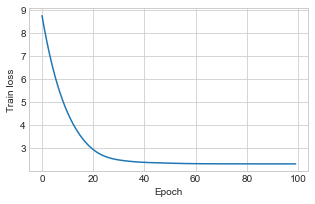

In [5]:
model = ElasticLinear(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=x_train.shape[1],
    l1_lambda=0.0,
    l2_lambda=0.0,
    learning_rate=0.05,
)

# fit model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader_train, dataloader_test)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

plot_convergence(model.train_log)

Now we fit an equivalent model in `sklearn`.

In [6]:
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression()
model_lin.fit(x_train, y_train)

LinearRegression()

Comparing the fitted coefficients we see that the models are nearly identical:

<ipython-input-7-1a7960f2f30d>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


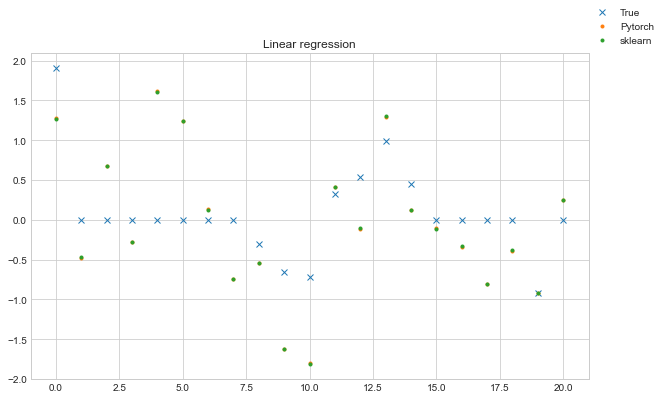

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, "x", label="True")
ax.plot(w_model, ".", label="Pytorch")
ax.plot(np.append(model_lin.intercept_, model_lin.coef_), ".", label="sklearn")
ax.set_title("Linear regression")
fig.legend()
fig.show()

## Ridge regression
Next let's test the ridge regression case, where we have only L2 regularisation.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 21    
-----------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, loss=7.41, v_num=54]         /Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wo

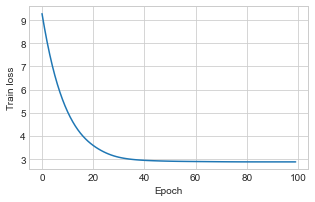

In [8]:
model = ElasticLinear(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=x_train.shape[1],
    l1_lambda=0.00,
    l2_lambda=0.05,
    learning_rate=0.05,
)

# fit model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader_train, dataloader_test)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

plot_convergence(model.train_log)

To fit an equivalent model in `sklearn` we need to adjust the regularisation value a bit.

$$loss = ||y - Xw||^2_2 + alpha * ||w||^2_2$$

Here `sklearn` doesnt use the MSE rather the SSE,
therefore we need to scale the alpha term by the training size to be consistent.

In [9]:
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha=0.05*x_train_t.shape[0])
model_ridge.fit(x_train, y_train)

Ridge(alpha=2.5)

Comparing the fitted coefficients once again we see that the models are nearly identical:

<ipython-input-10-07c5066c875c>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


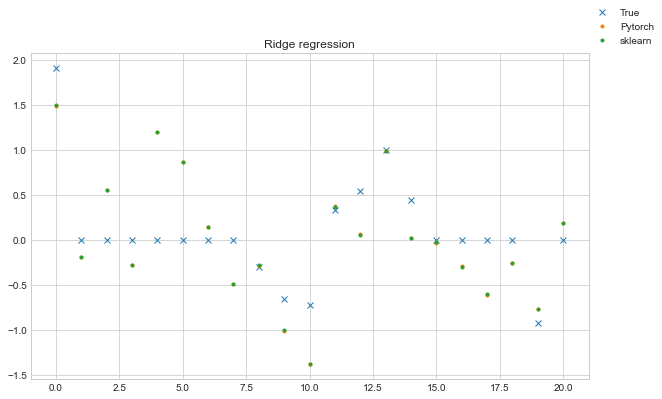

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, "x", label="True")
ax.plot(w_model, ".", label="Pytorch")
ax.plot(np.append(model_ridge.intercept_, model_ridge.coef_), ".", label="sklearn")
ax.set_title("Ridge regression")
fig.legend()
fig.show()

## Lasso regression
Next up is lasso regression case, where we have only L1 regularisation.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 21    
-----------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, loss=7.57, v_num=55]         /Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wo

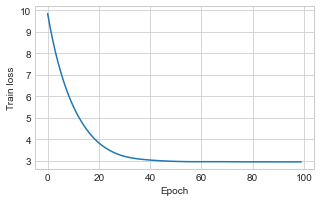

In [11]:
model = ElasticLinear(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=x_train.shape[1],
    l1_lambda=0.05,
    l2_lambda=0.0,
    learning_rate=0.05,
)

# fit model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader_train, dataloader_test)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

plot_convergence(model.train_log)

To fit an equivalent model in `sklearn` the alpha value we need is out by a factor of 2.

$$loss = (1 / (2 * n_{samples})) * ||y - Xw||^2_2 + alpha * ||w||_1$$

So we adjust the parameter appropriately.

In [12]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.05/2)
model_lasso.fit(x_train, y_train)

Lasso(alpha=0.025)

Comparing the fitted coefficients once again we see that the models are nearly identical:

<ipython-input-13-0f08a247de27>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


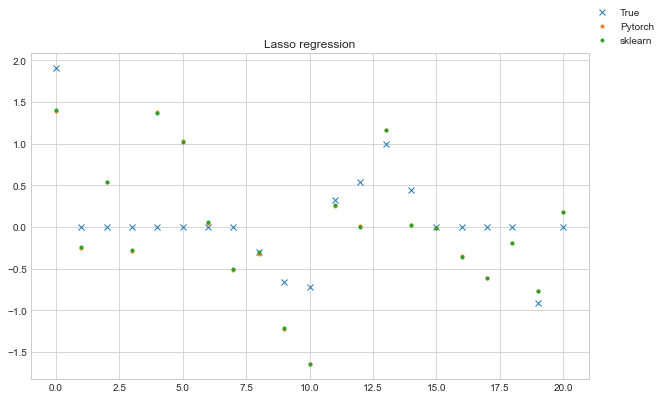

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, "x", label="True")
ax.plot(w_model, ".", label="Pytorch")
ax.plot(np.append(model_lasso.intercept_, model_lasso.coef_), ".", label="sklearn")
ax.set_title("Lasso regression")
fig.legend()
fig.show()

## ElasticNet regression
Finally we have the elastic net regression case, where we have both L1 and L2 regularisation.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 21    
-----------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, loss=6.55, v_num=56]/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

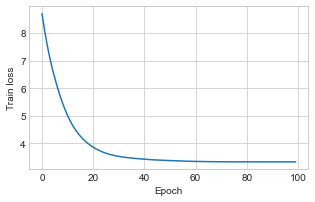

In [14]:
# ElasticNet
model = ElasticLinear(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=x_train.shape[1],
    l1_lambda=0.05,
    l2_lambda=0.05,
    learning_rate=0.05,
)

# fit model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader_train, dataloader_test)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

plot_convergence(model.train_log)

For `sklearn` the loss function is given as:

$$1 / (2 * n_{samples}) * ||y - Xw||^2_2$$
$$+ alpha * l1_{ratio} * ||w||_1$$
$$+ 0.5 * alpha * (1 - l1_{ratio}) * ||w||^2_2$$

To adjust the parameters we use the following:
```
a = 0.05 / 2
b = 0.05
alpha = a + b and l1_ratio = a / (a + b)
```

In [15]:
from sklearn.linear_model import ElasticNet
model_elastic = ElasticNet(alpha=0.075, l1_ratio=1/3)
model_elastic.fit(x_train, y_train)

ElasticNet(alpha=0.075, l1_ratio=0.3333333333333333)

And no surprises here that the fitted coefficients once again are nearly identical:

<ipython-input-16-fe6d54c07cff>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


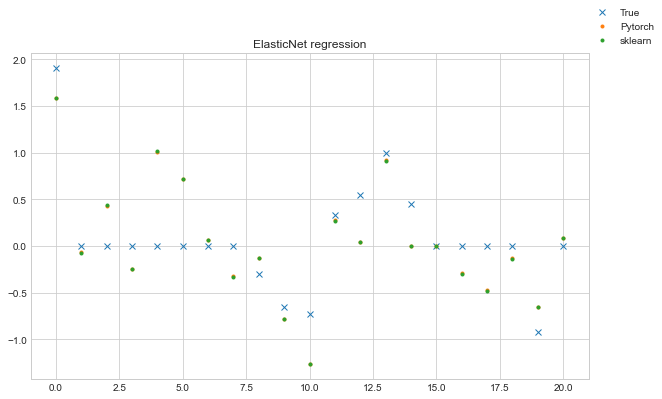

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, "x", label="True")
ax.plot(w_model, ".", label="Pytorch")
ax.plot(np.append(model_elastic.intercept_, model_elastic.coef_), ".", label="sklearn")
ax.set_title("ElasticNet regression")
fig.legend()
fig.show()